In [66]:
import pandas as pd
import geopandas as gpd
import numpy as np
import leafmap
import rasterio
import matplotlib.pyplot as plt
import pickle
import tomllib

In [68]:
CONFIG_FILE_PATH = "config.toml"
with open(CONFIG_FILE_PATH, "rb") as f:
    data_config = tomllib.load(f)
data_config = data_config["datapaths"]
maxar_fires_path = f"{data_config["data_root"]}{data_config["Maxar_images_path"]}Canada_2023"

In [12]:
leafmap.maxar_collections()

['BayofBengal-Cyclone-Mocha-May-23',
 'Belize-Wildfires-June24',
 'Brazil-Flooding-May24',
 'Cyclone-Chido-Dec15',
 'Earthquake-Myanmar-March-2025',
 'Emilia-Romagna-Italy-flooding-may23',
 'Floods-Spain-Oct24',
 'Gambia-flooding-8-11-2022',
 'Hurricane-Fiona-9-19-2022',
 'Hurricane-Ian-9-26-2022',
 'Hurricane-Idalia-Florida-Aug23',
 'HurricaneHelene-Oct24',
 'HurricaneMilton-Oct24',
 'Iceland-Volcano_Eruption-Dec-2023',
 'India-Floods-Oct-2023',
 'Indonesia-Earthquake22',
 'Japan-Earthquake-Jan-2024',
 'Kahramanmaras-turkey-earthquake-23',
 'Kalehe-DRC-Flooding-5-8-23',
 'Kenya-Flooding-May24',
 'Libya-Floods-Sept-2023',
 'Marshall-Fire-21-Update',
 'Maui-Hawaii-fires-Aug-23',
 'McDougallCreekWildfire-BC-Canada-Aug-23',
 'Morocco-Earthquake-Sept-2023',
 'NWT-Canada-Aug-23',
 'Nepal-Earthquake-Apr-2015',
 'Nepal-Earthquake-Nov-2023',
 'Nepal-Floods-Sept-2024',
 'New-Zealand-Flooding23',
 'Nigeria-Flooding-May-2025',
 'Nigeria-Floods-Sept-2024',
 'PNG-Landslide-June24',
 'SmokeHouseCree

In [2]:
maxar_fires = [
    "Belize-Wildfires-June24",
    "Marshall-Fire-21-Update",
    "Maui-Hawaii-fires-Aug-23",
    "McDougallCreekWildfire-BC-Canada-Aug-23",
    "NWT-Canada-Aug-23",
    "SmokeHouseCreek-Wildfires-Texas-Mar24",
    "WildFires-LosAngeles-Jan-2025"
]

In [3]:
imagery_types = [
    "visual", 
    "ms_analytic", 
    "pan_analytic", 
    "data-mask"
]

In [ ]:
# maxar_data = []
# for fire in maxar_fires:
#     collections = leafmap.maxar_child_collections(fire)
#     for c in collections:
#         for imagery in imagery_types:
#             gdf = leafmap.maxar_items(
#                 collection_id=fire,
#                 child_id=c,
#                 return_gdf=True,
#                 assets=[imagery],
#             )

#             if imagery == "visual":
#                 gdf_main = gdf.copy()
#             else:
#                 gdf_main[imagery] = gdf[imagery]

#         if(c == collections[0]):
#             fire_gdf = gdf_main.copy()
#         else:
#             fire_gdf = pd.concat([fire_gdf, gdf_main], ignore_index=True)
#     maxar_data.append(fire_gdf)

In [5]:
with open("maxar_data.pkl", 'rb') as f:
    maxar_data = pickle.load(f)

In [11]:
collections = leafmap.maxar_child_collections(maxar_fires[3])
collections

['10300100D3067400', '105001002D3C0200']

In [ ]:
canada1 = maxar_data[3]
canada2 = maxar_data[4]
canada2

In [12]:
canada1_col1 = canada1[canada1["catalog_id"] == collections[0]]

In [ ]:
canada1_col1

In [159]:
m = leafmap.Map()
m.add_gdf(canada1, layer_name="Footprints", zoom_to_layer=True, info_mode="on_click")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [48]:
images = canada1_col1["data-mask"].tolist()

# List of desired image codes
desired_ids = ["013331213213"]

# Filter all matching images
filtered_images = [url for url in images if any(code in url for code in desired_ids)]

filtered_images

['https://maxar-opendata.s3.amazonaws.com/events/McDougallCreekWildfire-BC-Canada-Aug-23/ard/11/013331213213/2022-05-18/10300100D3067400-data-mask.gpkg']

In [49]:
leafmap.maxar_download(filtered_images, out_dir="./Temporary_Files/")

Downloading...
From: https://maxar-opendata.s3.amazonaws.com/events/McDougallCreekWildfire-BC-Canada-Aug-23/ard/11/013331213213/2022-05-18/10300100D3067400-data-mask.gpkg
To: /Users/abdullah/Documents/WUI_Fire_Modelling/WUI_Risk_Analysis/Temporary_Files/10300100D3067400/013331213213.tif
100%|██████████| 98.3k/98.3k [00:00<00:00, 242kB/s]


In [52]:
data_mask = gpd.read_file("./Temporary_Files/10300100D3067400/canada-data-mask.gpkg")

<Axes: >

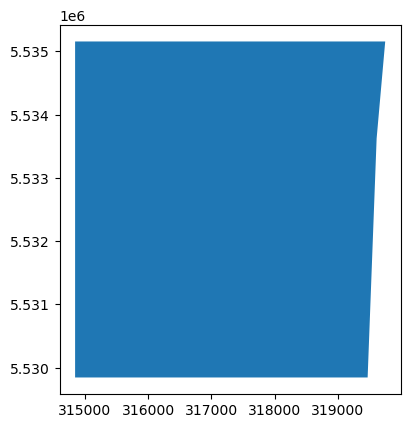

In [55]:
data_mask.plot()

In [75]:
can_pan = rasterio.open(f"{maxar_fires_path}/canada-pan.tif")
cpan_img = can_pan.read()
cpan_img = np.transpose(cpan_img, (1, 2, 0)) 
cpan_img.shape

(11032, 11032, 1)

In [79]:
cpan_img.max()

np.uint16(10000)

In [136]:
c_vals = cpan_img.astype(np.float32).ravel()
c_vals = c_vals[~np.isnan(c_vals)]

In [155]:
p_low, p_high = np.nanpercentile(c_vals, (1, 99))
norm_cpan = np.clip((cpan_img - p_low) / (p_high - p_low), 0, 1)

In [156]:
nc_vals = norm_cpan.astype(np.float32).ravel()
nc_vals = nc_vals[~np.isnan(nc_vals)]

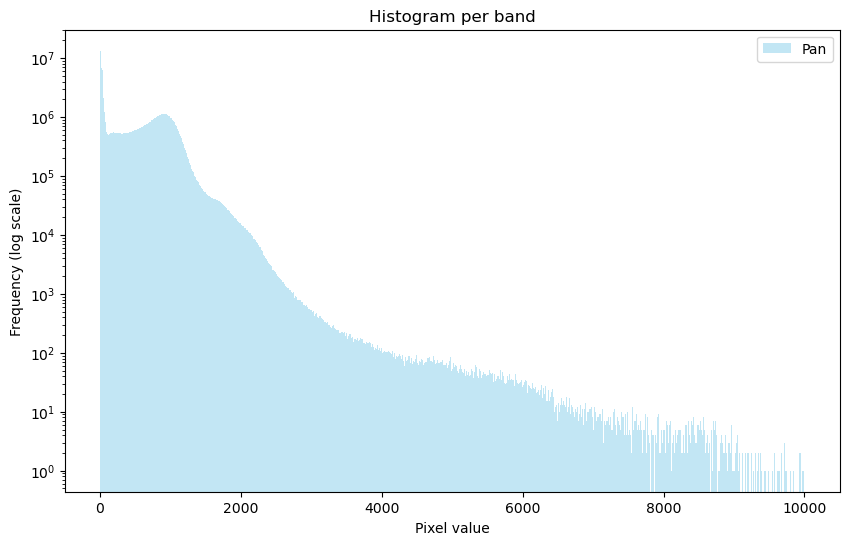

In [152]:
plt.figure(figsize=(10,6))
plt.hist(c_vals, bins=1000, alpha=0.5, label=f"Pan", color="skyblue")
plt.xlabel("Pixel value")
plt.ylabel("Frequency (log scale)")
plt.yscale("log")
plt.legend()
plt.title("Histogram per band")
plt.show()

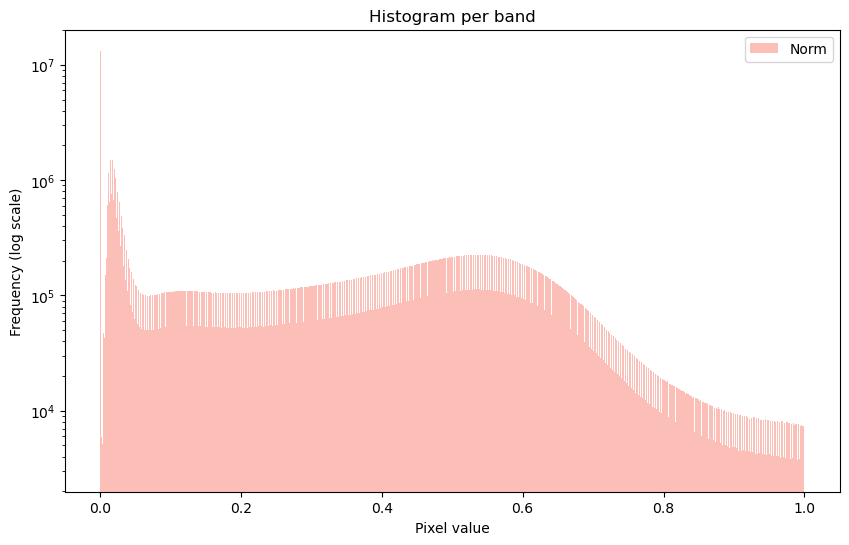

In [157]:
plt.figure(figsize=(10,6))
plt.hist(nc_vals, bins=1000, alpha=0.5, label=f"Norm", color="salmon")
plt.xlabel("Pixel value")
plt.ylabel("Frequency (log scale)")
plt.yscale("log")
plt.legend()
plt.title("Histogram per band")
plt.show()

In [160]:
norm_cpan.shape

(11032, 11032, 1)

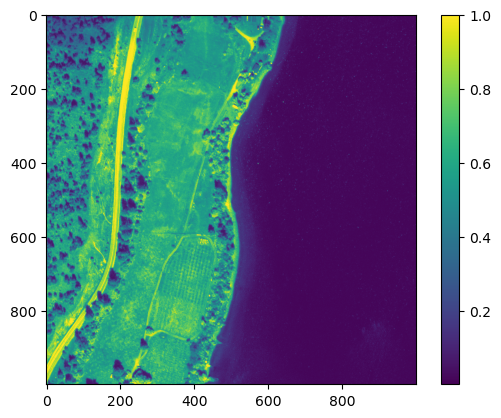

In [158]:
plt.imshow(norm_cpan[9500:10500, 5500:6500, :])
plt.colorbar()
plt.show()

In [63]:
path = "./Temporary_Files/10300100D3067400/canada.tif"
with rasterio.open(path) as src:
    print(src.transform)
    print(src.count)

| 0.31, 0.00, 314843.75|
| 0.00,-0.31, 5535156.25|
| 0.00, 0.00, 1.00|
3


In [30]:
canada_img = maui_first.read()

In [45]:
canada_img[7,:,:].min()

np.uint16(0)

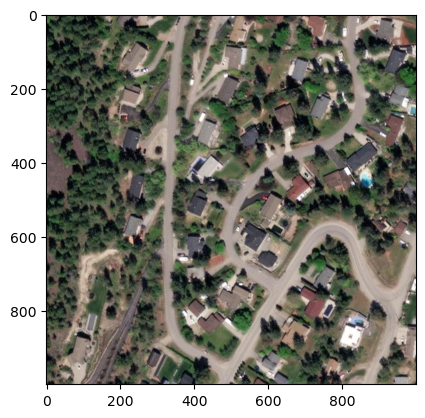

In [22]:
cropped_img = maui_img[14500:15500, 6500:7500, :]
plt.imshow(cropped_img)
plt.show()

In [ ]:
m = leafmap.Map() 
m.add_raster("./Temporary_Files/10300100D3067400/013331213213.tif", layer_name="Maxar Visual")
m

Map(center=[49.916984, -119.5422825], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

TraitError: Invalid selection: value not found